# 03_explore_results

Now we look at the vertical displacement from our InSAR processing compared to the SNOTEL SWE for a lot more data than we did for 02_SNOTEL_ifg_comp

> **NOTE** The documentation for this notebook is still very much unfinished

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob

In [84]:
# TODO: fix processing code, why so many duplicates?? oops
df_asc = pd.concat([pd.read_parquet(f) for f in glob.glob("../data/*asc*.parquet")])
print(f"number of observations for asc: {len(df_asc)}")
print(f"dropping duplicates...")
df_asc = df_asc.drop_duplicates()
print(f"number of observations for asc: {len(df_asc)}")

number of observations for asc: 4515
dropping duplicates...
number of observations for asc: 210


In [85]:
# TODO: fix processing code, why so many duplicates?? oops
df_desc = pd.concat([pd.read_parquet(f) for f in glob.glob("../data/*desc*.parquet")])
print(f"number of observations for desc: {len(df_desc)}")
print(f"dropping duplicates...")
df_desc = df_desc.drop_duplicates()
print(f"number of observations for desc: {len(df_desc)}")

number of observations for desc: 6125
dropping duplicates...
number of observations for desc: 245


In [86]:
df_asc['track'] = 'asc'
df_desc['track'] = 'desc'
df_all = pd.concat([df_asc, df_desc], ignore_index=True)
df_all['reference_date'] = df_all['reference_date'].astype(str)

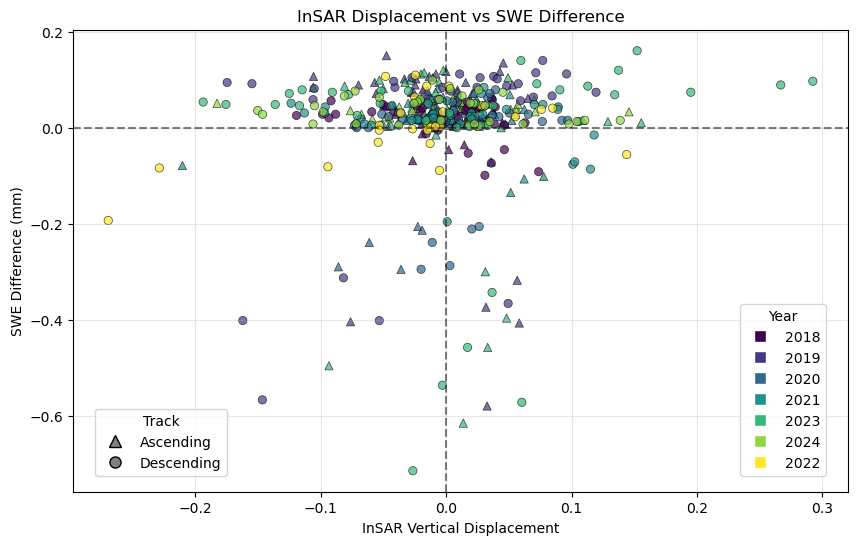

In [83]:
plt.figure(figsize=(10, 6))

years = df_all['reference_date'].str[:4].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(years)))
color_dict = dict(zip(years, colors))

for track in ['asc', 'desc']:
    mask = df_all['track'] == track
    data = df_all[mask]
    
    point_colors = [color_dict[year] for year in data['reference_date'].str[:4]]
    
    marker = '^' if track == 'asc' else 'o'
    
    plt.scatter(data['insar_vert_disp'],
               data['swe_diff'],
               marker=marker,
               c=point_colors,
               alpha=0.7,
               edgecolors='black',
               linewidth=0.5)

plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
plt.xlabel('InSAR Vertical Displacement')
plt.ylabel('SWE Difference (mm)')
plt.title('InSAR Displacement vs SWE Difference')
legend_elements = [plt.Line2D([0], [0], marker="s", color='w',
                            markerfacecolor=color, label=year,
                            markersize=8,)
                  for year, color in color_dict.items()]
first_legend = plt.legend(handles=legend_elements, title='Year',
                         loc='lower right', bbox_to_anchor=(0.98, 0.02))
track_elements = [
    plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='gray',
               label='Ascending', markersize=8, markeredgecolor='black'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
               label='Descending', markersize=8, markeredgecolor='black')
]
plt.gca().add_artist(first_legend)
plt.legend(handles=track_elements, title='Track',
          loc='lower left', bbox_to_anchor=(0.02, 0.02))

plt.grid(True, alpha=0.3);

In [87]:
# Remove outliers
for col in ['insar_vert_disp', 'swe_diff']:
    lower = df_all[col].quantile(0.02)
    upper = df_all[col].quantile(0.98)
    df_all = df_all[(df_all[col] >= lower) & (df_all[col] <= upper)]

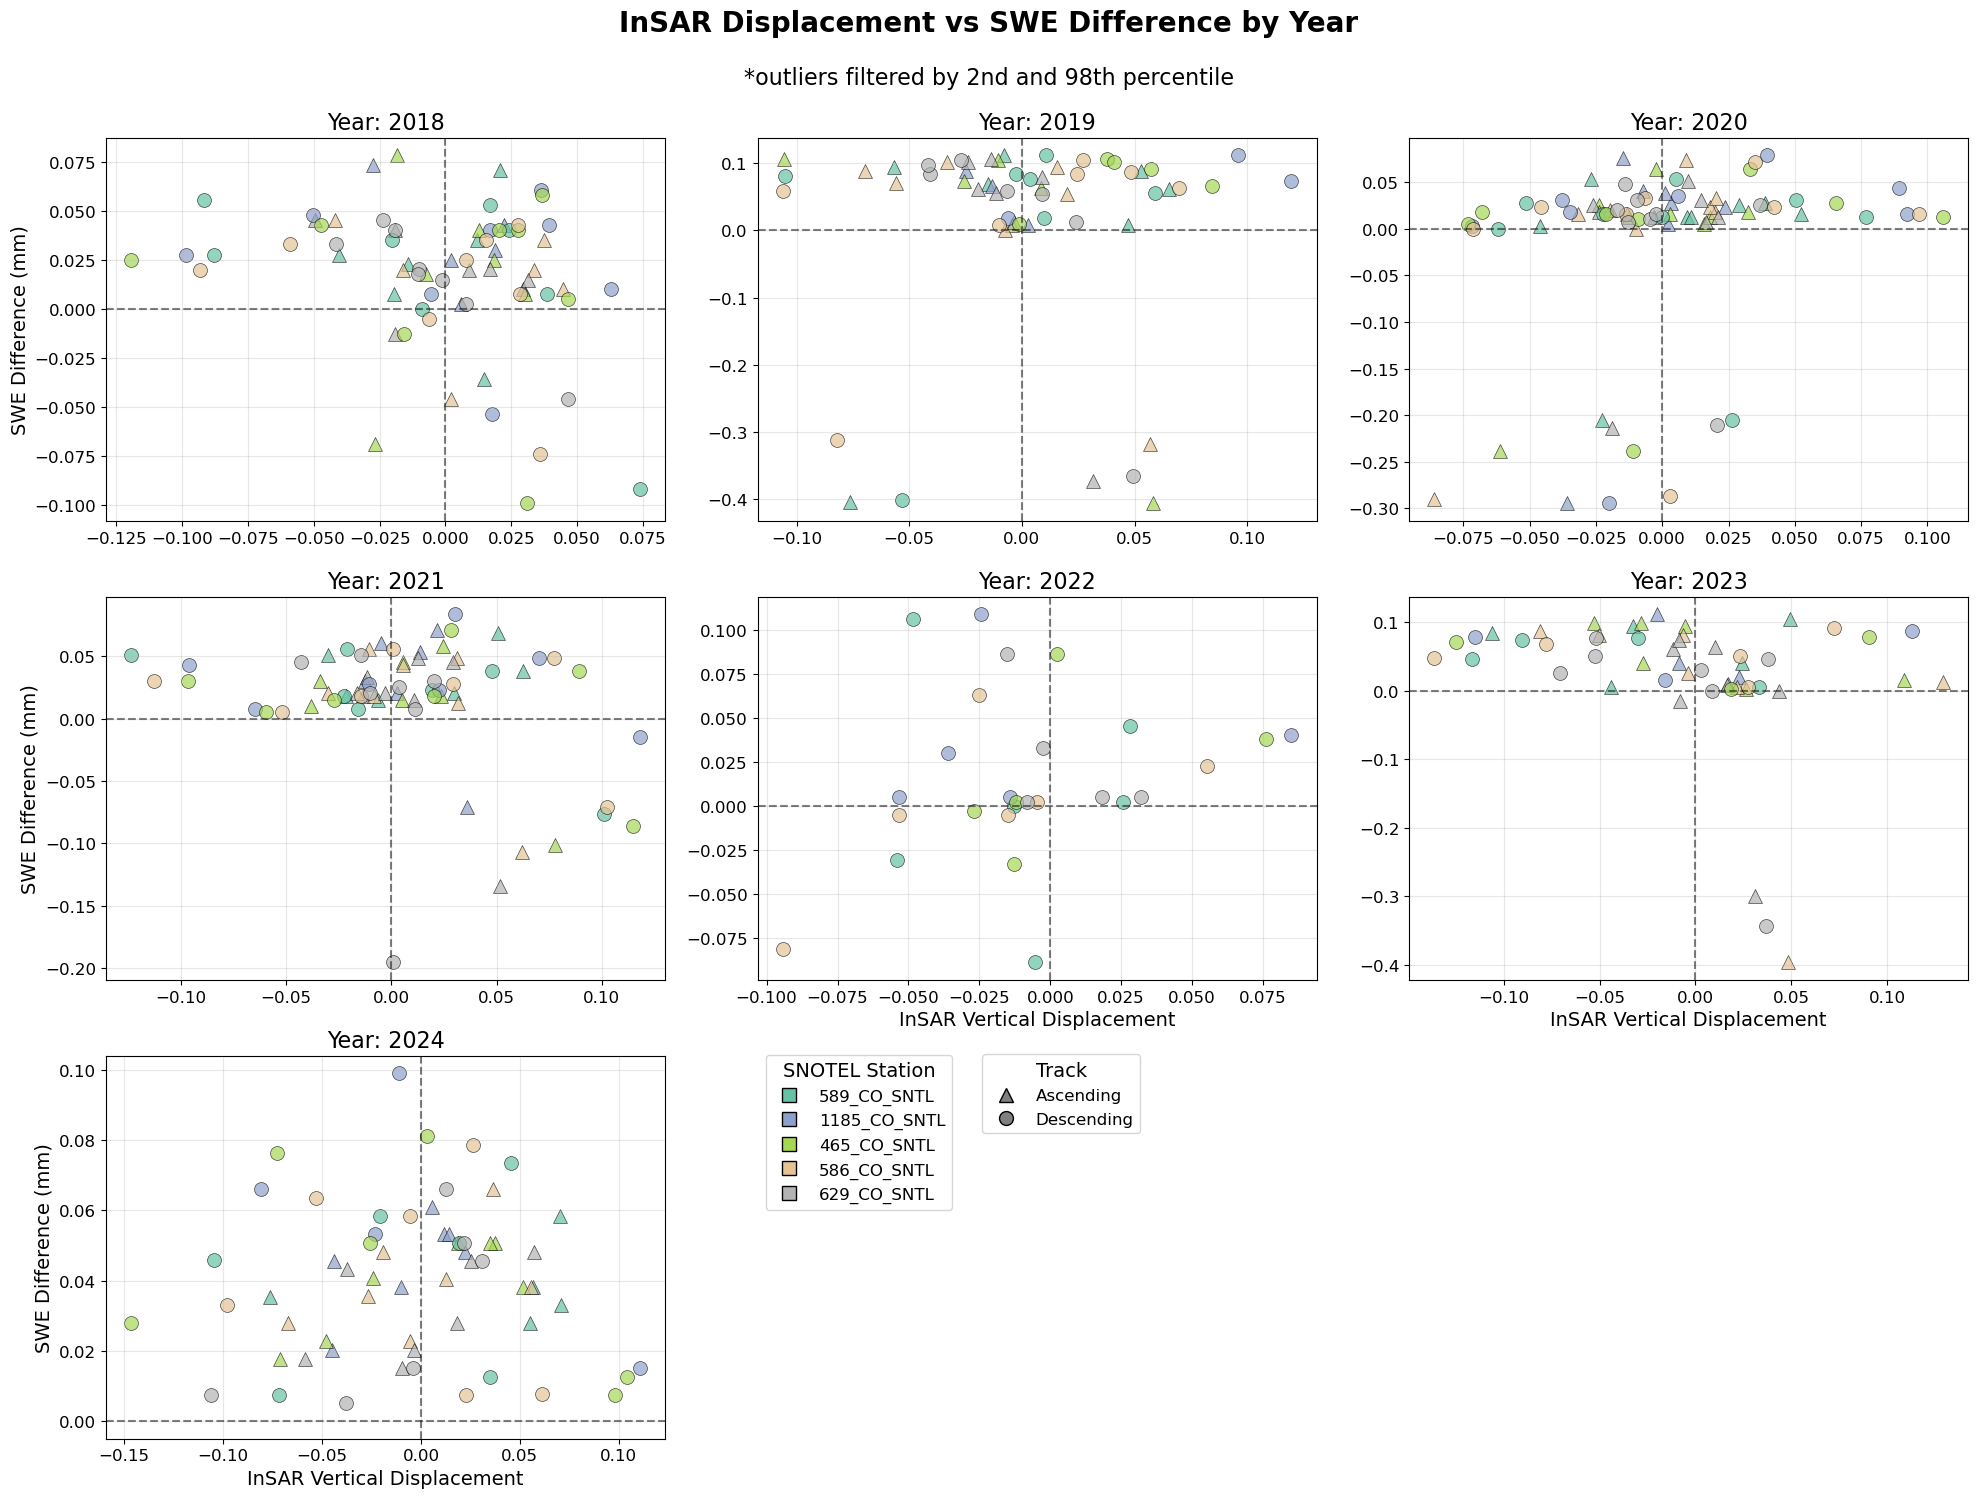

In [117]:
# Create figure with subplots
fig, axs = plt.subplots(3, 3, figsize=(20, 15))
axs = axs.ravel()

plt.rcParams.update({'font.size': 14})  # Increase base font size

# Get unique SNOTEL codes and create color mapping
sntl_codes = df_all['sntl_code'].unique()
colors = plt.cm.Set2(np.linspace(0, 1, len(sntl_codes)))
color_dict = dict(zip(sntl_codes, colors))

# Plot each year separately
for idx, year in enumerate(sorted(years)):
    ax = axs[idx]
    year_mask = df_all['reference_date'].str[:4] == year
    year_data = df_all[year_mask]
    
    for track in ['asc', 'desc']:
        track_mask = year_data['track'] == track
        data = year_data[track_mask]
        
        marker = '^' if track == 'asc' else 'o'
        
        for sntl in sntl_codes:
            sntl_mask = data['sntl_code'] == sntl
            ax.scatter(data[sntl_mask]['insar_vert_disp'],
                      data[sntl_mask]['swe_diff'],
                      marker=marker,
                      c=[color_dict[sntl]],
                      alpha=0.7,
                      edgecolors='black',
                      linewidth=0.5,
                      s=100)  # Increased marker size
    
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    ax.grid(True, alpha=0.3)
    ax.set_title(f'Year: {year}', fontsize=16)
    
    if idx >= 6 or idx==4 or idx==5:
        ax.set_xlabel('InSAR Vertical Displacement', fontsize=14)
    if idx % 3 == 0:
        ax.set_ylabel('SWE Difference (mm)', fontsize=14)
    
    ax.tick_params(axis='both', which='major', labelsize=12)

# Create legends with larger markers
sntl_elements = [plt.Line2D([0], [0], marker='s', color='w',
                           markerfacecolor=color, label=code,
                           markersize=10, markeredgecolor='black')
                 for code, color in color_dict.items()]

track_elements = [
    plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='gray',
               label='Ascending', markersize=10, markeredgecolor='black'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
               label='Descending', markersize=10, markeredgecolor='black')
]

# Add legends with larger font
leg1 = axs[-2].legend(handles=sntl_elements, title='SNOTEL Station',
                      loc='center left', bbox_to_anchor=(0, .8),
                      fontsize=12, title_fontsize=14)
axs[-2].add_artist(leg1)
leg2 = axs[-2].legend(handles=track_elements, title='Track',
                      loc='center right', bbox_to_anchor=(0.7, .9),
                      fontsize=12, title_fontsize=14)
axs[-2].set_axis_off()

# Remove last empty subplot
axs[-1].remove()

plt.suptitle("InSAR Displacement vs SWE Difference by Year\n", fontsize=20, fontweight="bold", y=1.0)
plt.figtext(0.5, 0.95, "*outliers filtered by 2nd and 98th percentile", 
            ha='center', fontsize=16)
plt.tight_layout();

Note how getting rid of outlier removed all Ascending points from 2022

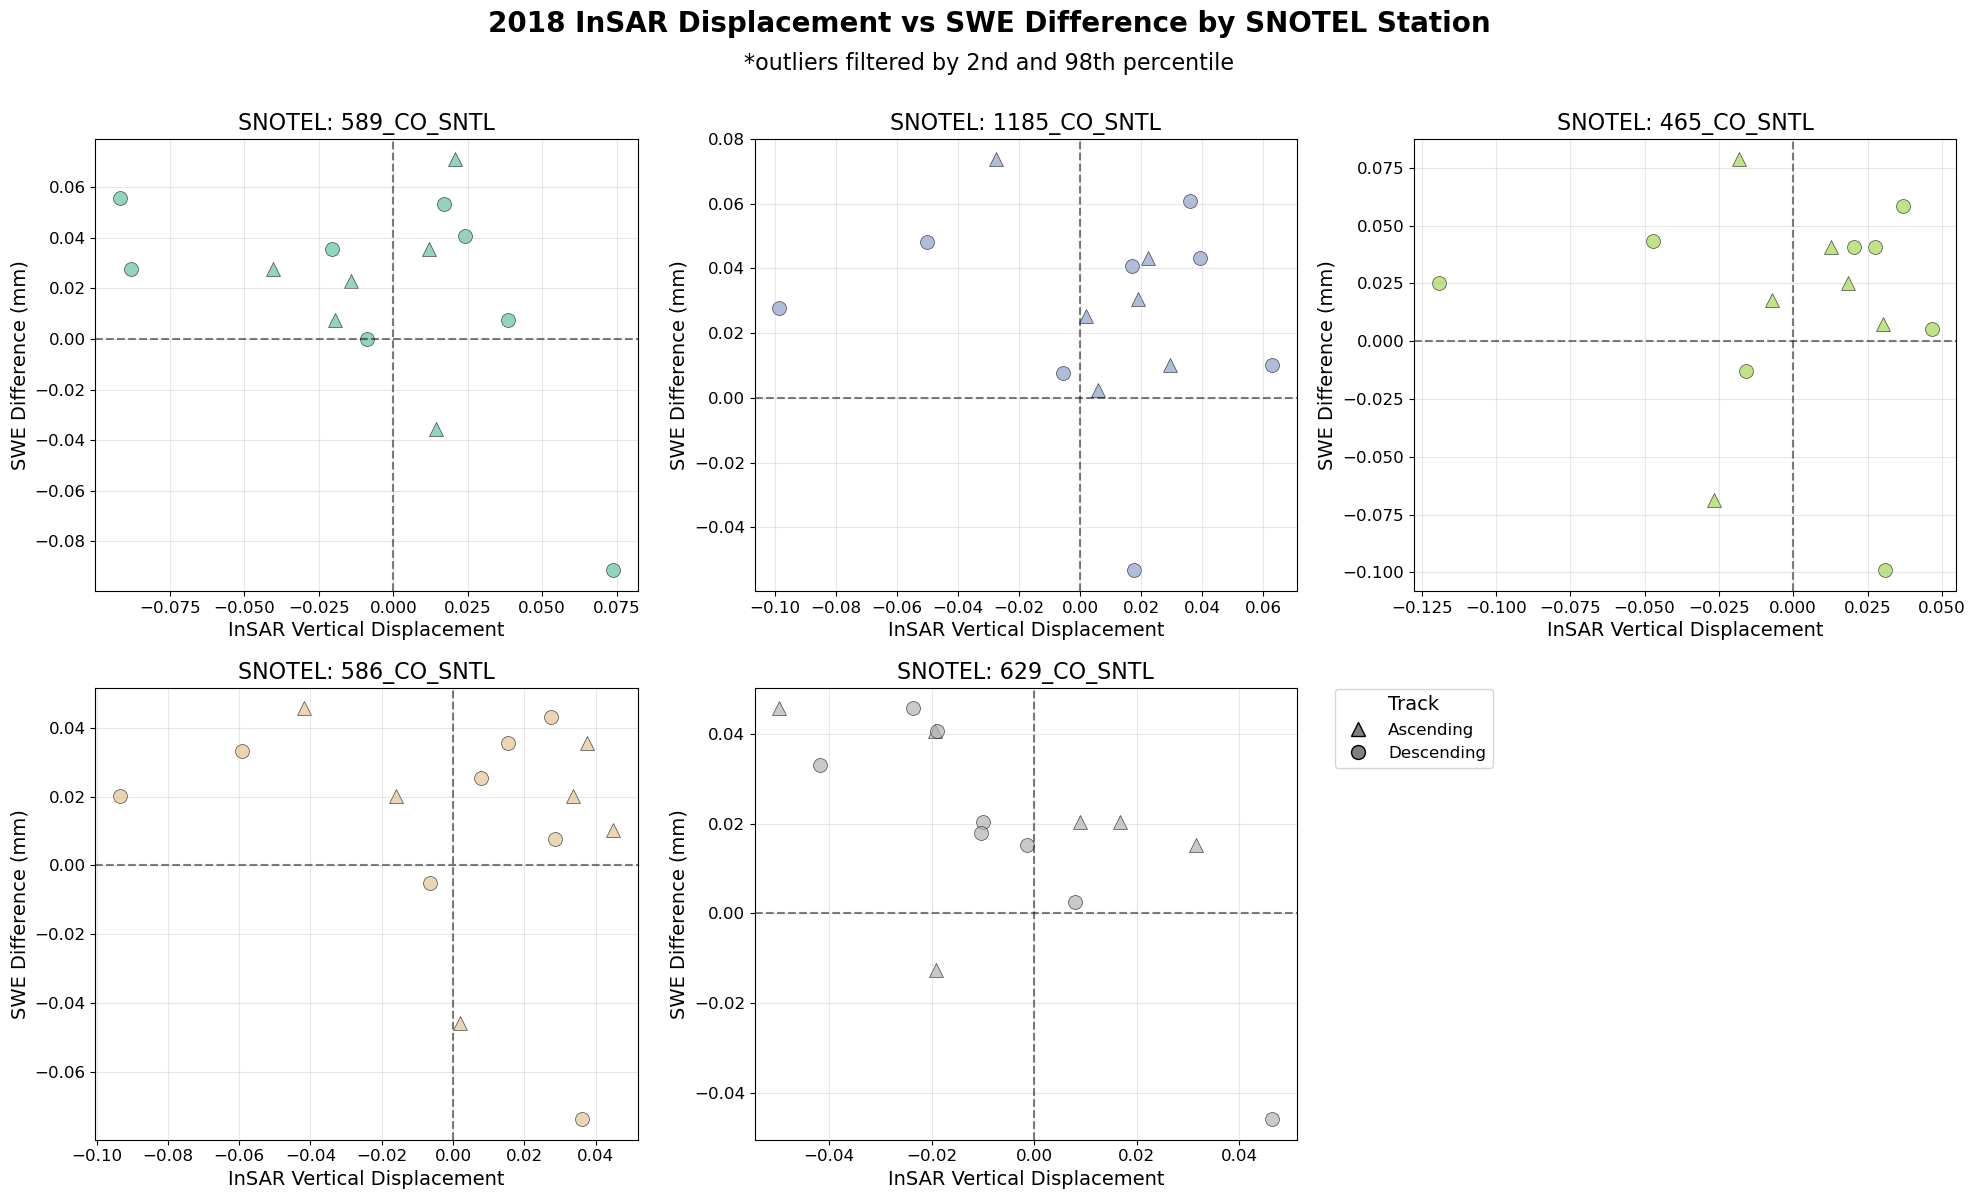

In [124]:
# Create figure with subplots
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
axs = axs.ravel()

# Filter for 2018 data
year_mask = df_all['reference_date'].str[:4] == '2018'
year_data = df_all[year_mask]

# Plot each SNOTEL station separately
for idx, sntl in enumerate(sntl_codes):
    ax = axs[idx]
    sntl_mask = year_data['sntl_code'] == sntl
    data = year_data[sntl_mask]
    
    for track in ['asc', 'desc']:
        track_mask = data['track'] == track
        track_data = data[track_mask]
        
        marker = '^' if track == 'asc' else 'o'
        
        ax.scatter(track_data['insar_vert_disp'],
                  track_data['swe_diff'],
                  marker=marker,
                  c=[color_dict[sntl]],
                  alpha=0.7,
                  edgecolors='black',
                  linewidth=0.5,
                  s=100)

    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    ax.grid(True, alpha=0.3)
    ax.set_title(f'SNOTEL: {sntl}', fontsize=16)
    ax.set_xlabel('InSAR Vertical Displacement', fontsize=14)
    ax.set_ylabel('SWE Difference (mm)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)

# Create track type legend
track_elements = [
    plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='gray',
               label='Ascending', markersize=10, markeredgecolor='black'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
               label='Descending', markersize=10, markeredgecolor='black')
]

# Add legend
leg = axs[-1].legend(handles=track_elements, title='Track',
                     loc='center', fontsize=12, title_fontsize=14,
                     bbox_to_anchor=(0,.91))
axs[-1].set_axis_off()

plt.suptitle("2018 InSAR Displacement vs SWE Difference by SNOTEL Station\n", 
             fontsize=20, fontweight="bold", y=1.0)
plt.figtext(0.5, 0.95, "*outliers filtered by 2nd and 98th percentile", 
            ha='center', fontsize=16)
plt.tight_layout()

In [ ]:
# TODO: SNOTEL time series of other vars between reference and secondary
# TODO: Sentinel-1 time series of other vars between reference and secondary (snow mask?)
# TODO: ERA-5 time series of other vars between reference and secondary